# Short_range National Water Model Forecast
### Workflow for creating an 18 hour stream flow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [1]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json

import dask 
from dask.distributed import Client, LocalCluster
# import dask.bag as db
from multiprocessing import cpu_count

%matplotlib inline

## Start the local cluster
#### *__NOTE__*: this is *currently* equal or slower in computation time because of the overhead of the dask scheduler. Without the local cluster, xarray operates serially.

In [2]:
num_workers = cpu_count()
cluster = LocalCluster(n_workers=num_workers)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:63464 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.21 GB


## Set up the Google Cloud File System

In [3]:
fs = gcsfs.GCSFileSystem(project='national-water-model')
# alldays = fs.ls('national-water-model')
# len(alldays)

## Open all netcdf files of interest, concat them into an xarray multifile dataset

- This step takes longer than expected due to reading from GCS over the internet

In [15]:
date = '20190730' # todays date
start_time = '00' # start at 00:00 
open_ncdfs = []
for i in range(1,19): # for times 1-18
    hr_from_start = str(i).zfill(3)
    filepath = f'national-water-model/nwm.{date}/short_range/nwm.t{start_time}z.short_range.channel_rt.f{hr_from_start}.conus.nc'
    file = fs.open(filepath, 'rb')
    open_ncdfs.append(file)
mfdset = xr.open_mfdataset(open_ncdfs)
mfdset

<xarray.Dataset>
Dimensions:         (feature_id: 2729077, reference_time: 1, time: 18)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2019-07-30
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
  * time            (time) datetime64[ns] 2019-07-30T01:00:00 ... 2019-07-30T18:00:00
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    streamflow      (time, feature_id) float64 dask.array<shape=(18, 2729077), chunksize=(1, 2729077)>
    nudge           (time, feature_id) float64 dask.array<shape=(18, 2729077), chunksize=(1, 2729077)>
    velocity        (time, feature_id) float64 dask.array<shape=(18, 2729077), chunksize=(1, 2729077)>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<shape=(18, 2729077), chunksize=(1, 2729077)>
    qBucket         (time, feature_id) float64 dask.array<shape=(18, 2729077), chunksize=(1, 2729077)>
    qBtmVertRunoff  (time, feature_id) float64 dask.array<shape

## Get only the streamflow data for the COMID of interest

In [6]:
comid = 4512772
output_da = mfdset.sel(feature_id=comid)['streamflow']
output_da

<xarray.DataArray 'streamflow' (time: 18)>
dask.array<shape=(18,), dtype=float64, chunksize=(1,)>
Coordinates:
    feature_id  int32 4512772
  * time        (time) datetime64[ns] 2019-07-30T01:00:00 ... 2019-07-30T18:00:00
Attributes:
    long_name:     River Flow
    units:         m3 s-1
    coordinates:   latitude longitude
    grid_mapping:  crs
    valid_range:   [      0 5000000]

# What is the desired output JSON format?

In [8]:
test_output = {'COMID': comid, 'data': dict(zip(output_da['time'].values.astype(str), output_da.values))}
print(json.dumps(test_output, sort_keys=True, indent=4))

{
    "COMID": 4512772,
    "data": {
        "2019-07-30T01:00:00.000000000": 154.149996554479,
        "2019-07-30T02:00:00.000000000": 163.80999633856118,
        "2019-07-30T03:00:00.000000000": 171.6599961631,
        "2019-07-30T04:00:00.000000000": 177.9199960231781,
        "2019-07-30T05:00:00.000000000": 182.25999592617154,
        "2019-07-30T06:00:00.000000000": 184.9199958667159,
        "2019-07-30T07:00:00.000000000": 186.27999583631754,
        "2019-07-30T08:00:00.000000000": 186.73999582603574,
        "2019-07-30T09:00:00.000000000": 186.59999582916498,
        "2019-07-30T10:00:00.000000000": 186.08999584056437,
        "2019-07-30T11:00:00.000000000": 185.35999585688114,
        "2019-07-30T12:00:00.000000000": 184.48999587632716,
        "2019-07-30T13:00:00.000000000": 183.55999589711428,
        "2019-07-30T14:00:00.000000000": 182.59999591857195,
        "2019-07-30T15:00:00.000000000": 181.62999594025314,
        "2019-07-30T16:00:00.000000000": 180.6599959619

In [9]:
print(json.dumps(output_da.to_dict(), indent=4, default=str))

{
    "dims": [
        "time"
    ],
    "attrs": {
        "long_name": "River Flow",
        "units": "m3 s-1",
        "coordinates": "latitude longitude",
        "grid_mapping": "crs",
        "valid_range": [
            0,
            5000000
        ]
    },
    "data": [
        154.149996554479,
        163.80999633856118,
        171.6599961631,
        177.9199960231781,
        182.25999592617154,
        184.9199958667159,
        186.27999583631754,
        186.73999582603574,
        186.59999582916498,
        186.08999584056437,
        185.35999585688114,
        184.48999587632716,
        183.55999589711428,
        182.59999591857195,
        181.62999594025314,
        180.65999596193433,
        179.70999598316848,
        178.76999600417912
    ],
    "coords": {
        "feature_id": {
            "dims": [],
            "attrs": {
                "long_name": "Reach ID",
                "comment": "NHDPlusv2 ComIDs within CONUS, arbitrary Reach IDs outside o

# Plot it and compare to a plot grabbed from the Hydroshare NWM forecast Viewer

In [13]:
# get an array of the streamflow values in cms
output_arr = output_da.values
output_arr

array([154.14999655, 163.80999634, 171.65999616, 177.91999602,
       182.25999593, 184.91999587, 186.27999584, 186.73999583,
       186.59999583, 186.08999584, 185.35999586, 184.48999588,
       183.5599959 , 182.59999592, 181.62999594, 180.65999596,
       179.70999598, 178.769996  ])

In [11]:
# cms_to_cfs_factor = 35.31467
# cfsout = output_arr*cms_to_cfs_factor

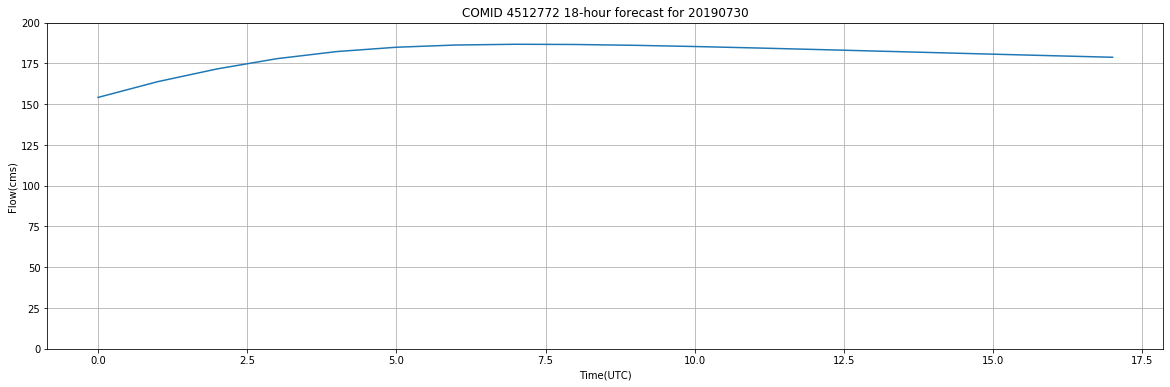

In [18]:
# plot it
fig, ax = plt.subplots(figsize=(20, 6))
ax.grid(True, which="both")
ax.plot(output_arr)
ax.set_ylabel('Flow(cms)')
ax.set_xlabel('Time(UTC)')

ax.set_title(f'COMID {comid} 18-hour forecast for {date}')
ax.set_autoscaley_on(False)
ax.set_ylim([0,200])

plt.show()

### This is the Hydroshare NWM Forecast Viewer we are trying to mimic:
![COMID 4512772 from HydroShare NWM Forecast Viewer](images/hydroshare_forecast_4512772.jpg)

In [19]:
[f.close() for f in open_ncdfs];